In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import InstanceHardnessThreshold
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [ ]:
'''CONFIG FOR LOCAL / CLOUD RUNNING'''
running_local = 'content' not in os.getcwd()
if running_local:
    path = ''
else:
   from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
path = 'drive/MyDrive'

In [ ]:
import os
import pandas as pd
dfs = []
for filename in os.listdir(path + '/features_ring'):
    if filename[-4:] == '.tsv':
        dfs.append(pd.read_csv(path + '/features_ring/' + filename, sep='\t'))
df = pd.concat(dfs)
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,3m8j,B,27,,S,-,0.392,13.0,13.0,-1.452,...,13.0,-1.300,-0.640,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND
1,3m8j,B,40,,S,S,0.131,18.0,13.0,-1.366,...,18.0,-1.097,-0.699,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
2,3m8j,A,15,,L,H,0.671,4.0,14.0,-1.117,...,10.0,-1.054,-0.687,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
3,3m8j,A,26,,G,T,0.548,5.0,15.0,1.196,...,13.0,-1.305,-0.605,H,-1.019,-0.987,-1.505,1.266,-0.912,VDW
4,3m8j,B,19,,R,H,0.698,5.0,15.0,-1.042,...,14.0,-0.905,2.275,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,3l1e,A,97,,H,E,0.288,5.0,21.0,-2.252,...,10.0,-2.610,2.797,H,-1.006,-0.590,1.891,-0.397,0.412,NaN
101,3l1e,A,78,,K,T,0.566,4.0,18.0,-1.058,...,11.0,1.606,0.381,L,-0.384,1.652,1.330,1.045,2.064,NaN
102,3l1e,A,130,,S,E,0.500,6.0,17.0,-2.473,...,19.0,-1.979,2.317,H,-1.006,-0.590,1.891,-0.397,0.412,NaN
103,3l1e,A,92,,D,T,0.411,7.0,10.0,1.082,...,18.0,-1.201,2.327,H,1.538,-0.055,1.502,0.440,2.897,HBOND


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2481880 entries, 0 to 104
Data columns (total 34 columns):
 #   Column       Dtype  
---  ------       -----  
 0   pdb_id       object 
 1   s_ch         object 
 2   s_resi       int64  
 3   s_ins        object 
 4   s_resn       object 
 5   s_ss8        object 
 6   s_rsa        float64
 7   s_up         float64
 8   s_down       float64
 9   s_phi        float64
 10  s_psi        float64
 11  s_ss3        object 
 12  s_a1         float64
 13  s_a2         float64
 14  s_a3         float64
 15  s_a4         float64
 16  s_a5         float64
 17  t_ch         object 
 18  t_resi       int64  
 19  t_ins        object 
 20  t_resn       object 
 21  t_ss8        object 
 22  t_rsa        float64
 23  t_up         float64
 24  t_down       float64
 25  t_phi        float64
 26  t_psi        float64
 27  t_ss3        object 
 28  t_a1         float64
 29  t_a2         float64
 30  t_a3         float64
 31  t_a4         float64
 32  t_a5   

In [ ]:
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
HBOND        903606
VDW          641755
PIPISTACK     33033
IONIC         30409
PICATION       7645
PIHBOND        1838
SSBOND         1809
Name: count, dtype: int64


In [ ]:
df = df[df.Interaction.notna()]
contact_dict = {"HBOND": 0, "VDW": 1, "PIPISTACK": 2, "IONIC": 3, "PICATION": 4, "PIHBOND": 5, "SSBOND": 6,  }
y = df['Interaction']
cat_names = list(y.astype('category').cat.categories)
y.replace(contact_dict, inplace=True)
X = df[['s_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

<ipython-input-74-6130092e4844>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace(contact_dict, inplace=True)


In [ ]:
# Scale the features
minMax = MinMaxScaler()
X_scaled = minMax.fit_transform(X)

In [ ]:
X_scaled

array([[0.2       , 0.15555556, 0.17860554, ..., 0.41428026, 0.9177934 ,
        0.37954064],
       [0.15555556, 0.24444444, 0.27427571, ..., 0.14051165, 0.50540833,
        0.        ],
       [0.22222222, 0.24444444, 0.1281439 , ..., 0.79699631, 0.69442942,
        1.        ],
       ...,
       [0.2       , 0.44444444, 0.33397007, ..., 0.69135802, 0.        ,
        0.49812673],
       [0.22222222, 0.28888889, 0.33970073, ..., 0.41428026, 0.9177934 ,
        0.37954064],
       [0.22222222, 0.33333333, 0.10347023, ..., 0.79699631, 0.69442942,
        1.        ]])

In [ ]:
input_dim = X_scaled.shape[1]
num_classes = len(contact_dict)
print("Input dimension:", input_dim)  # 18

Input dimension: 18


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.1, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from collections import Counter

In [ ]:
class_distribution = Counter(y_train)
print("Original class distribution:", class_distribution)

sampling_strategy = {
    0: 813245,  # HBOND
    1: 813245,  # VDW
    2: 300000,  # PIPISTACK
    3: 300000,  # IONIC
    4: 10000,  # PICATION
    5: 10000,  # PIHBOND
    6: 10000   # SSBOND
}
oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_bal, y_bal = oversample.fit_resample(X_train, y_train)

# Convert labels to categorical format
y_cat = to_categorical(y_bal, num_classes)

# Verify the resampled data
print('Original y_train distribution:', Counter(y_train))
print('Resampled y_bal distribution:', Counter(y_bal))

Original class distribution: Counter({0: 813245, 1: 577579, 2: 29730, 3: 27368, 4: 6881, 5: 1654, 6: 1628})
Original y_train distribution: Counter({0: 813245, 1: 577579, 2: 29730, 3: 27368, 4: 6881, 5: 1654, 6: 1628})
Resampled y_bal distribution: Counter({0: 813245, 1: 813245, 2: 300000, 3: 300000, 4: 10000, 6: 10000, 5: 10000})


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
def init():
  model = Sequential()
  model.add(Input(input_dim))
  model.add(Dense(units=128, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=128, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=128, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=128, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=128, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=num_classes, activation='softmax', kernel_initializer="glorot_normal"))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['AUC'])
  return model

mdl = init()
mdl.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_205 (Dense)           (None, 128)               2432      
                                                                 
 dense_206 (Dense)           (None, 128)               16512     
                                                                 
 dense_207 (Dense)           (None, 128)               16512     
                                                                 
 dense_208 (Dense)           (None, 128)               16512     
                                                                 
 dense_209 (Dense)           (None, 128)               16512     
                                                                 
 dense_210 (Dense)           (None, 7)                 903       
                                                                 
Total params: 69383 (271.03 KB)
Trainable params: 693

In [ ]:
es = EarlyStopping(
                       monitor='loss',
                       mode='min',
                       patience=5,
                       min_delta=0.0001
                       )
fold = 0
hist = []
for train_idx, val_idx in kf.split(X_bal, y_bal):
  fold += 1
  print(f"Fold {fold}/10")
  Xfold_train, Xfold_val = X_bal[train_idx], X_bal[val_idx]
  yfold_cat_train, yfold_cat_val = y_cat[train_idx], y_cat[val_idx]
  metrics = mdl.fit(Xfold_train, yfold_cat_train,
          validation_data=(Xfold_val, yfold_cat_val),
          epochs=500, verbose=1,
          batch_size=16000,
          callbacks=[es])
  hist.append(metrics)


Fold 1/10
Epoch 1/500
127/127 [==============================] - 3s 7ms/step - loss: 0.9790 - auc: 0.9116 - val_loss: 0.7510 - val_auc: 0.9395
Epoch 2/500
127/127 [==============================] - 1s 5ms/step - loss: 0.7224 - auc: 0.9423 - val_loss: 0.7102 - val_auc: 0.9435
Epoch 3/500
127/127 [==============================] - 1s 5ms/step - loss: 0.7060 - auc: 0.9440 - val_loss: 0.7045 - val_auc: 0.9448
Epoch 4/500
127/127 [==============================] - 1s 5ms/step - loss: 0.7010 - auc: 0.9449 - val_loss: 0.6996 - val_auc: 0.9452
Epoch 5/500
127/127 [==============================] - 1s 4ms/step - loss: 0.6986 - auc: 0.9452 - val_loss: 0.6998 - val_auc: 0.9446
Epoch 6/500
127/127 [==============================] - 1s 5ms/step - loss: 0.6964 - auc: 0.9456 - val_loss: 0.6967 - val_auc: 0.9461
Epoch 7/500
127/127 [==============================] - 1s 5ms/step - loss: 0.6949 - auc: 0.9460 - val_loss: 0.6942 - val_auc: 0.9465
Epoch 8/500
127/127 [==============================] - 1s 5

5063/5063 [==============================] - 7s 1ms/step
Accuracy:  0.5477871736312573
AUC:  0.7968227808305078


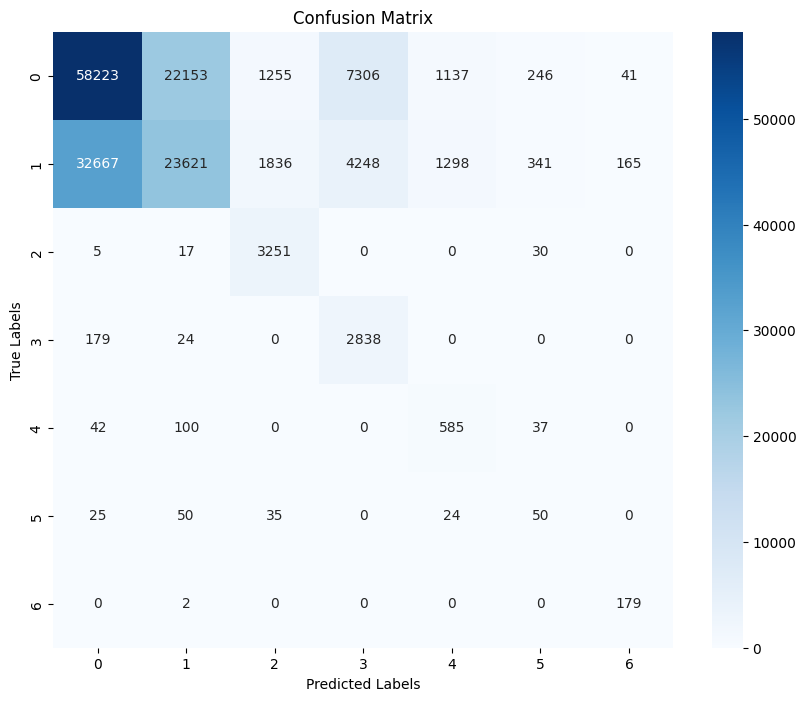

              precision    recall  f1-score   support

           0       0.64      0.64      0.64     90361
           1       0.51      0.37      0.43     64176
           2       0.51      0.98      0.67      3303
           3       0.20      0.93      0.33      3041
           4       0.19      0.77      0.31       764
           5       0.07      0.27      0.11       184
           6       0.46      0.99      0.63       181

    accuracy                           0.55    162010
   macro avg       0.37      0.71      0.45    162010
weighted avg       0.58      0.55      0.55    162010



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def report(model, X_test, y_test):
    outputs = model.predict(X_test)
    y_pred = np.argmax(outputs, axis=1)
    y_true = y_test

    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: ", accuracy)

    # Binarize labels and compute ROC AUC
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=np.arange(num_classes))
    auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
    print("AUC: ", auc)

    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Plotting confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return report

report = report(mdl, X_test, y_test)
print(report)

In [ ]:
mdl.save(path + 'model/keras/mdl234boost.keras')